# A Walkthrough of *Exact Stochastic Simulation of Coupled Chemical Reactions* By Danlel T. Gillespie

## Part 2 - Writing the Gillespie Algorithm

### Learning Goals of Part 2

In this seciton the Gillespie algorithm will be written out in Python. We will then apply the same constants to the algorithm as we did to the exponential decay function from part 1. We will then compare the outputs.

#### Stochastic vs Deterministic

The most important thing to understand about this type of model(stochastic) is the way it handles the time variable. In many models there is a chosen $\Delta t$ so that every time interval the model considers would be in an increment of $\Delta t$. The problem with that approach, because we want to model every individual 'reaction', is that these reactions are not reasonably garunteed to occur on an increment of $\Delta t$.

The Gillespie Stochastic algorithm gets around this problem by calculating the probable time that elapses before any given reaction occurs. The reaction is then simulated and the time value is incremented.

In [1]:
# import the same packages. 
# It is better form to do these on individual lines.
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# The list of initial values of species to will track
exp_X = [1000]

# The list of rate constants
exp_c = [0.5]

# the change in X that results from the change from rate constant c
# in this case X = X - 1
# since one X decays and we do not track the decay product
exp_change = {1: lambda u: [u[0] - 1]}
# Where u[0] takes the first element from the X list

# and the H value is the number of distinct R, molecular reactant
# combinations available in the state
# In this case one for each
exp_H = {1: lambda u: u[0]}

In [3]:
class gillespie:

    def __init__(self, X_values, c_values, X_change, h_form, max_time, max_count):

        self.X_values = X_values
        self.c_values = c_values
        self.X_change = X_change
        self.h_form = h_form

        # some stopper variables so the simulation does not go on forever.
        self.max_time = max_time
        self.max_count = max_count

        # start at one with the count.
        self.count = 1
        self.time = 0

    # first thing to calculate is av = hv * cv
    # where v is an index
    def av_calc(self):
        return [self.h_form[v](self.X_values) *
                self.c_values[v - 1] for v in self.h_form]

    # Then calculate a0, which is the sum of the av values
    def a0_calc(self, avals):
        return sum(avals)

    # then tau, which is the probable length of time before any one
    # of the monitored reactions occurs.
    # r1 will be a random number we supply the function with
    # r1 will be between 0 and 1.0
    def tau_calc(self, asum, r1):
        return (1. / asum) * np.log(1. / r1)

    # next is mu, the random value
    # r2 is also between 0 and 1.0
    def mu_calc(self, avals, asum, r2):
        # start an index at 1
        u = 1
        # while r2 * ao is less than the successive sums of av
        # increase the u value by 1
        while sum(avals[:u]) < r2 * asum:
            u = u + 1
        return u

    # now define a simulation function
    def simulate(self):

        # an a list for output with the starting time, should be 0
        time_out = [0]
        # an empty list that contains the X values, include the starting
        # here, as it will change after the first pass of the algorithm.
        X_out = [self.X_values]

        # while we haven't hit the heat death of the universe...
        # if self.max_time is None:
        while (self.count < self.max_count) and \
            ((self.max_time is None) or (self.time < self.max_time)):
        # while (self.time < self.max_time) or \
            # ((self.max_time == None) and self.count < self.max_count):

            # calculate av
            av = self.av_calc()
            # print "1av: ", av

            # calculate a0
            a0 = self.a0_calc(av)
            # print "2a0: ", a0

            # generate random numbers
            r1, r2 = np.random.random(), np.random.random()

            # calculate tau
            tau = self.tau_calc(a0, r1)
            # print "3tau", tau

            # calculate mu
            mu = self.mu_calc(av, a0, r2)
            # print "4mu: ", mu

            # call the change function, and set
            self.X_values = self.X_change[mu](self.X_values)

            self.time = self.time + tau
            # print 'time: ', self.time
            time_out.append(self.time)
            X_out.append(self.X_values)

            self.count = self.count + 1

        return time_out, X_out


In [4]:
# set the out variables so we can plot, input the stuff from above
simT, simX = gillespie(exp_X, exp_c, exp_change, exp_H, 10, 1000).simulate()

In [5]:
tt2 = gillespie(exp_X, exp_c, exp_change, exp_H, 10, 1000).simulate()

### Examine the output of Gillespe exponential decay

The function gillespe().simulate(), when loaded with variables, returns two lists:
- The time list.
- The X values list.
Since X can be multiple values it will need to be unpacked in some cases. For this we will use the zip(\*X_values) function. zip is a built in that unpacks or packs lists.

In [6]:
# what is the length of our output list? It should be 1000.
# As we had 1000 molecules to simulate, and this should take
# 1000 runs through the algorithm
print("Count of simT and simX:\n\tsimT: {}\n\tsimX: {}\n".format(len(simT), len(simX)))
print("First and last values:")
print("\tsimT first:\t {}\n\tsimT last:\t {}".format(simT[0], simT[-1]))

Count of simT and simX:
	simT: 991
	simX: 991

First and last values:
	simT first:	 0
	simT last:	 10.335458813414668


## Plot the output

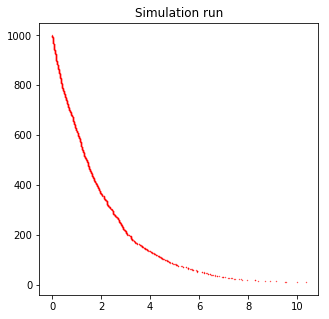

In [7]:
plt.figure(1, figsize=(5,5))
plt.scatter(simT, simX, marker=".", s=.5, alpha=0.9, color = 'r')
plt.title("Simulation run")
plt.show()

### Compare the output to the deterministic solution.

In [8]:
def exponential_decay(X, c, t):
    return X * np.exp(-c * t)

time_range = np.linspace(0, 10, 1000)

exp = exponential_decay(1000, 0.5, time_range)

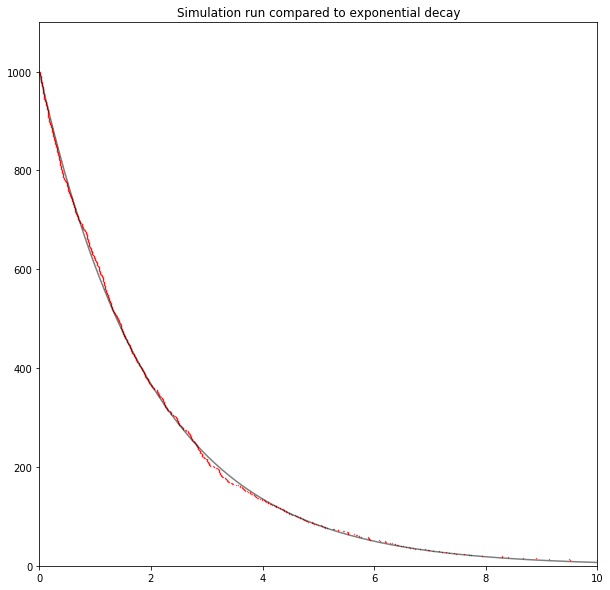

In [9]:
plt.figure(2, figsize=(10,10))
plt.title("Simulation run compared to exponential decay")

plt.xlim(0, time_range[-1])
plt.ylim(0, 1100)

plt.scatter(simT, simX, marker=".", s=.5, alpha=0.9, color = 'r')
plt.plot(time_range, exp, 'k', alpha=0.5, linewidth=1.5)
plt.show()

### Series of Simulations
We do not want to have to type a run name for every stochastic simulation. Especially since in many cases we will want to examine data from many individual simulations. Python makes this pretty easy, we are just going to define a list that contains 100 instances of this class.

In [11]:
# to run many simsulations make a list of runs
exp_runs = [gillespie(exp_X, exp_c, exp_change, exp_H, 10, 1000).simulate() for i in range(100)]

### Plot many simulations

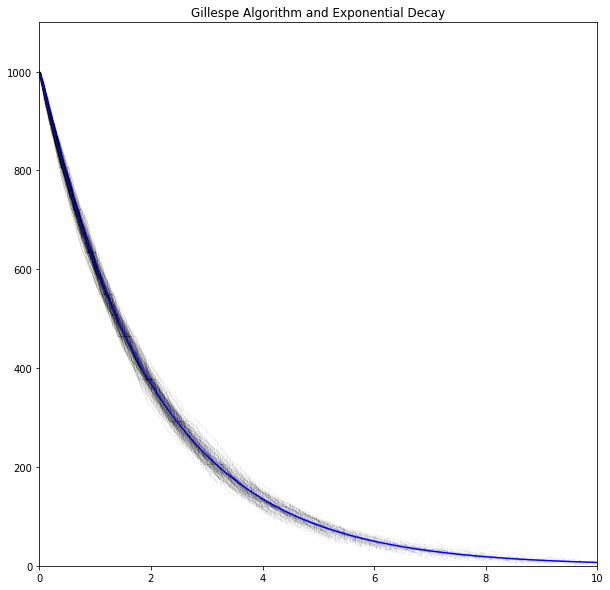

In [12]:
plt.figure(3, figsize=(10,10))
plt.ylim(0, 1100)
plt.xlim(0,10)
# Plot the exp decay function, so we can compare
plt.plot(time_range, exp, 'b', linewidth=1.5)

# for every item (run) in the list exp_runs
for run in exp_runs:
    # unzip the data
    r = zip(*run)
    t, x = zip(*r)
    plt.scatter(t, x, marker=".", s=.1, alpha=0.1, color='k')
    
plt.title('Gillespe Algorithm and Exponential Decay')
plt.show()